# Fitting Kinetic constants to Arrhenius Equation

In this assignment, we will try to fit the the kinetic constants obtained in the given reaction system to an Arrhenius model.

The model is:

$$ k(T) = A e^\frac{-E_a}{RT} $$

Wherein we will estimate the values of the paramters A and Ea from the given values of kinetic constants (k) at various temperatures (T).

The dataset available is as shown below.

In [499]:
import pandas as pd
d= {'Temperature_C':[250,300,350,400],'k1':[4.1e-2,8.03e-2,1.36e-1,1.90e-1,],'k1_err':[5.63e-2,1.55e-1,4.42e-1,6.51e-1],
    'k2':[7.17e-4,1.85e-3,4.29e-3,1.13e-2],'k2_err':[1.83e-4,4.2e-4,1.43e-3,6.07e-3]}
df= pd.DataFrame(d)

In [500]:
df


,Temperature_C,k1,k1_err,k2,k2_err
0,250,0.0410,0.0563,0.000717,0.000183
1,300,0.0803,0.1550,0.001850,0.000420
2,350,0.1360,0.4420,0.004290,0.001430
3,400,0.1900,0.6510,0.011300,0.006070


Let us first plot the constants and their errors as they are. 

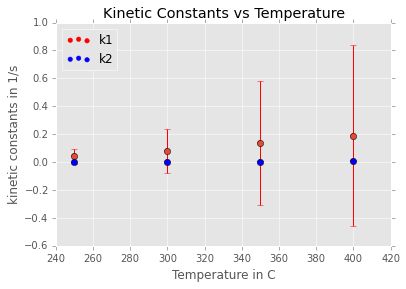

In [501]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.gridlines= True
%matplotlib inline
figure = plt.figure()
ax= figure.add_subplot(111)
ax.scatter(df.Temperature_C,df.k1,color= 'red',label= 'k1')
ax.scatter(df.Temperature_C,df.k2,color= 'blue',label = 'k2')
ax.errorbar(df.Temperature_C,df.k1,yerr=df.k1_err, fmt ='o',ecolor='red')
ax.errorbar(df.Temperature_C,df.k2,yerr= df.k2_err, fmt = 'o',color='blue',ecolor= 'blue')
ax.xaxis.label.set_text('Temperature in C')
ax.yaxis.label.set_text('kinetic constants in 1/s')
ax.title.set_text('Kinetic Constants vs Temperature')
ax.legend(loc=0)
fig.canvas.draw()
    


For better viewing ...

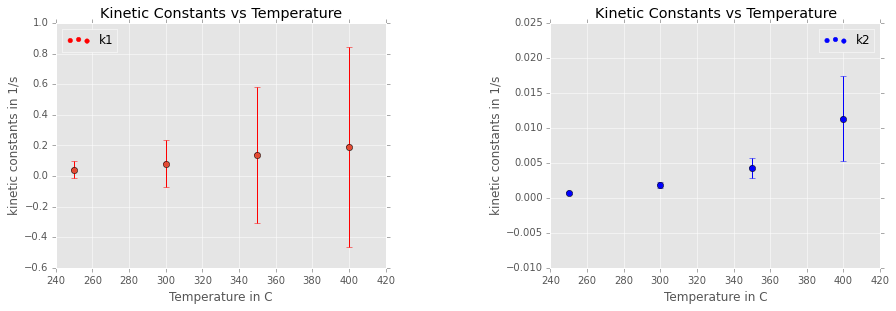

In [502]:
%matplotlib inline


fig= plt.figure()
ax1= fig.add_subplot(121);ax2= fig.add_subplot(122)
fig.tight_layout()
fig.subplots_adjust(wspace= 0.5)
fig.set_figwidth(13)

ax1.scatter(df.Temperature_C,df.k1,color= 'red',label= 'k1')
ax2.scatter(df.Temperature_C,df.k2,color= 'blue',label = 'k2')
ax1.errorbar(df.Temperature_C,df.k1,yerr=df.k1_err, fmt ='o',ecolor='red')
ax2.errorbar(df.Temperature_C,df.k2,yerr= df.k2_err, fmt = 'o',color= 'blue',ecolor= 'blue')
ax1.xaxis.label.set_text('Temperature in C')
ax2.xaxis.label.set_text('Temperature in C')
ax1.yaxis.label.set_text('kinetic constants in 1/s')
ax2.yaxis.label.set_text('kinetic constants in 1/s')
ax1.title.set_text('Kinetic Constants vs Temperature')
ax2.title.set_text('Kinetic Constants vs Temperature')
ax1.legend(loc=0);
ax2.legend(loc=0);
fig.canvas.draw()


Great! We have wonderfully large errors in the k1 values. Now, let's fit them using our model. 

Let us first write down a function for our model.

In [503]:
import scipy 
import scipy.optimize
def model(T, arr_params): #arr_params is a list or an array of arrhenius paramters A and Ea
    [A,Ea]= arr_params
    R= 8.314
    k= A*scipy.exp(-Ea/(R*(T+273.16)))
    return k

In [504]:
def plot(k1_fit, k2_fit,df): # k1_fit and k2_fit are the arrhenius params for the model
    %matplotlib inline 
    k1_unfitted = model(df.Temperature_C,k1_fit)
    k2_unfitted = model(df.Temperature_C,k2_fit)
    ax1.plot(df.Temperature_C, k1_unfitted,'r')
    ax2.plot(df.Temperature_C, k2_unfitted, 'b')
    return fig

Let us plot for some sample values to check if we are in the ballpark

We will now fit the constants

In [505]:
def error(k_param, df, k_number): # defining the error for some k values, k_param: Arrhenius constants, k_num: whether k1 or k2
    k_estimated = model(df.Temperature_C,k_param)
    k_number = 'k'+str(k_number)
    return 500*(k_estimated- df[k_number])

def fit_params(k_param, df, k_number):
    res= scipy.optimize.leastsq(error,k_param, args=(df,k_number), full_output=1)
    k_opt= res[0]; k_cov= res[1]
    return k_opt, k_cov


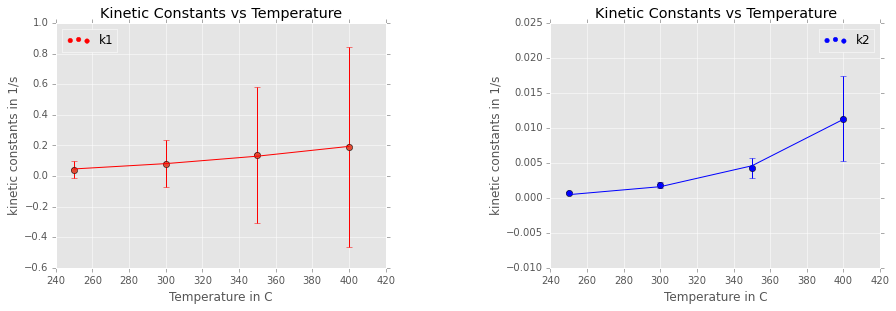

In [506]:
k2_fit=fit_params([25,28000],df,2)[0]
k1_fit= fit_params([25,28000],df,1)[0]
plot(k1_fit,k2_fit, df)


Looks good. Let's find out the confidence intervals.

In [507]:
import numpy as np
def get_confidence_intervals(k_param,df,k_number):
    k_params_opt= fit_params(k_param, df, k_number)[0]
    k_params_cov= fit_params(k_param, df, k_number)[1]
    k_optimized_values = model(df.Temperature_C, k_params_opt)
    
    partial_derivs = []
    for i in range(len(k_params_opt)):
        k_param= k_params_opt[i]
        dk_param= abs(k_param)/1e9+1e-20
        k_param= k_param + dk_param
        k_params_copy= k_params_opt
        k_params_copy[i]= k_param
        k_optimized_for_diff= model(df.Temperature_C, k_params_copy)
        dkdk_param= (k_optimized_for_diff - k_optimized_values)/dk_param
        partial_derivs.append(dkdk_param)
        k_param= k_param - dk_param
    
    partial_derivs = np.array((partial_derivs),)
    k_params_cov_for_errors= scipy.diag(scipy.diag(fit_params([2,25000], df, 1)[1])) #Taking the diag and then making 2x2 mattrix
    left= np.dot(partial_derivs.T,k_params_cov_for_errors)
    right= np.dot(left,partial_derivs)
    sigma_2 = scipy.diag(right)
    error= scipy.sqrt(sigma_2)
    return 1.96*error
        


In [508]:
confi_1= get_confidence_intervals([22,28000],df,1);
confi_2= get_confidence_intervals([22,28000],df,2);
k1_fitted = model(df.Temperature_C,k1_fit);
k2_fitted= model(df.Temperature_C, k2_fit);
plot(k1_fit,k2_fit,df);
ax1.fill_between(df.Temperature_C, k1_fitted - confi_1, k1_fitted + confi_1, color= '#ff0000', alpha= 0.2);
ax2.fill_between(df.Temperature_C, k2_fitted- confi_2, k2_fitted + confi_2, color= '#0000ff', alpha = 0.2);

print confi_1

[ 0.01505373  0.02504046  0.03839935  0.0552967 ]


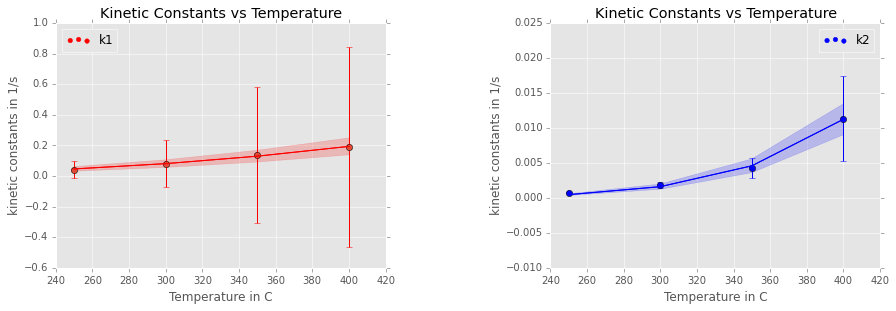

In [509]:
fig

Let's type down the final parameter values and their errors

In [510]:
k2_fit= fit_params([25,28000],df,2)[0]
k1_fit= fit_params([25,28000],df,1)[0]
k1_error= 1.96*scipy.sqrt(scipy.diag(fit_params([2,25000], df, 1)[1]))
k2_error= 1.96*scipy.sqrt(scipy.diag(fit_params([2,25000], df, 2)[1]))

d= {'A (1/s)':[k1_fit[0], k2_fit[0]], 'Error in A (1/s)':[k1_error[0],k2_error[0]], 'Ea (J/mol)':[k1_fit[1], k2_fit[1]], 
   'Error in Ea (J/mol)':[k1_error[1], k2_error[1]]}
df1= pd.DataFrame(d)

In [511]:
np.round(df1,3)

,A (1/s),Ea (J/mol),Error in A (1/s),Error in Ea (J/mol)
0,28.918,28030.993,6.587,1212.114
1,811.012,62612.225,7264.352,49378.910


Thus, the values of the kinetic constants have been fit to the Arrhenius model. The model is more accurate than the experimental data especially at high temperature. 